### Training a segmentation model to extract the cells from the C. elegans embryo

In [ ]:
!pip install --upgrade albumentations  
!pip install segmentation-models-pytorch
!pip install optuna

In [49]:
import os
import numpy as np
import cv2
from PIL import Image
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
from albumentations import *
import segmentation_models_pytorch as smp
import optuna

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Mount Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Copy and Extract Preprocessed Training Data from Google Drive

Access data:

* Csv file - [Link](https://drive.google.com/file/d/1-BE9yxcEW9i_-GPrIc7ABkosXOAKIES-/view?usp=sharing)
* Image data (zip) - [Link](https://drive.google.com/file/d/1wy53XglZl5Pgdq0V6pT3Q7DJeTheZmoh/view?usp=sharing)

In [6]:
!cp -r /content/drive/MyDrive/mydata/3d_seg_data/metadata_pil.csv /content/
!rsync -a -v /content/drive/MyDrive/mydata/3d_seg_data/training_data_pil.zip /content/
!unzip training_data_pil.zip

In [9]:
def erode(gray):
    kernel = np.ones((2,2),np.uint8)
    erosion = cv2.erode(gray,kernel,iterations = 1)
    return(erosion)

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [11]:
class SegmentationDataset(Dataset):   
    def __init__(self, metadata_csv, augmentation =None, transform_image = None, transform_label = None):

        self.metadata = pd.read_csv(metadata_csv) 
        self.image_paths  = self.metadata["image"]
        self.mask_paths  =  self.metadata["mask"]
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.augmentation = augmentation

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]))
        mask = np.array(Image.open(self.mask_paths[idx]))

        if self.augmentation is not None:
                
            augmented  = self.augmentation(image = image, mask = mask)
            image = augmented["image"]
            mask = augmented["mask"]
       
        mask[mask != 0] = 255
        mask = erode(np.uint8(mask))
        
        return self.transform_image(image), self.transform_label(mask)
    
    def __len__(self):
        return len(self.image_paths)

In [ ]:
full_dataset = SegmentationDataset(metadata_csv = "/content/metadata_pil.csv",
                                    augmentation =  Compose([GridDistortion(p=1.),
                                                             Transpose(p=0.5),
                                                             RandomRotate90(p=1.),
                                                             RandomBrightnessContrast(p=0.9),
                                                             ShiftScaleRotate(p=0.9),
                                                             OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=1),
                                                             ]),

                                    transform_image = transforms.Compose([ transforms.ToPILImage(),
                                                                          transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                                          ToTensor(),
                                                                          transforms.RandomApply([AddGaussianNoise( mean = 0.5,std= 0.05)], p=0.8)
                                                                          ]),                                  
                                    transform_label = transforms.Compose([transforms.ToPILImage(),
                                                                          transforms.Resize((256,256),interpolation = Image.NEAREST),
                                                                          ToTensor()
                                                                          ]))

In [ ]:
train_size = int(0.9* len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle = True, num_workers=2)
batch  = next(iter(train_loader))

images, masks = batch
fig, ax = plt.subplots(2, 2, figsize = (7,7))
fig.suptitle("Training Data (Sampled from Dataloader)")
for i in range(2):
    ax[i][0].imshow(images[i][0], cmap="gray")
    ax[i][0].set_title("Image")
    
    ax[i][1].imshow(masks[i][0], cmap="gray")
    ax[i][1].set_title("Segmentation Map")

    ax[i][0].axis('off')
    ax[i][1].axis('off')


In [42]:
def plot_metrics(train_iou_scores, valid_iou_scores, val_dice_losses, lrs):
    plt.rcParams['figure.figsize'] = 15, 4
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    clear_output(wait = True)
    ax1.plot(train_iou_scores, color='blue', label='train')
    ax1.plot(valid_iou_scores, color='green', label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_title('iou scores')
    ax2.plot(val_dice_losses, color = "green")
    ax2.grid()
    ax2.set_title('val dice loss')
    ax3.plot(lrs, color = "red")
    ax3.grid()
    ax3.set_title('learning rates')
    plt.show()


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [43]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [52]:
def run_training(epochs=2, lr=0.00015, batch_size=32, loss=loss, show_metrics=True, device='cuda', optuna=False):

    model = smp.FPN(
    encoder_name='resnet18', 
    encoder_weights='imagenet', 
    classes=1, 
    activation='sigmoid',
    in_channels = 1
    )

    optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=lr), 
    ])

    trainer = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=device,
        verbose=show_metrics,
        )

    validator = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=device,
        verbose=False,
    )
   
    scheduler = ReduceLROnPlateau(optimizer, 
                                    mode='min', 
                                    factor=0.7, 
                                    patience=7, 
                                    verbose=False, 
                                    threshold=0.0001, 
                                    threshold_mode='rel', 
                                    cooldown=0, 
                                    min_lr=0, 
                                    eps=1e-08)
    
    max_score = 0
    val_dice_losses, train_iou_scores, val_iou_scores, lrs = [],[],[],[]
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle = True, num_workers=2)

    if optuna:
      optuna_logs = trainer.run(val_loader)
      return(optuna_logs["iou_score"])

    for i in range(0, epochs):

        print('\nEpoch: {}'.format(i))

        train_logs = trainer.run(train_loader)
        valid_logs = validator.run(val_loader)
        val_dice_losses.append(valid_logs["dice_loss"]) 
        train_iou_scores.append(train_logs["iou_score"])
        val_iou_scores.append(valid_logs["iou_score"])
        scheduler.step(1.)
        lrs.append(get_lr(optimizer))

        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')

        if show_metrics:
            plot_metrics(train_iou_scores, val_iou_scores, val_dice_losses, lrs)

    return(max_score)

### Automated Hyperparameter Optimization (Optuna):
`n_trials` is the number of optuna trials, feel free to use any higher number.



In [ ]:
def objective(trial):
    params = {
        "lr": trial.suggest_uniform("lr", 0.5e-3 , 10e-3 ),
        "batch_size" : trial.suggest_int("batch_size", 8 , 64, )}
        
    score  = run_training(epochs = 1,
                          lr =  params["lr"],
                          batch_size = params["batch_size"],
                          loss=loss, 
                          device=device,
                          optuna=True)

    return(score)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

### View Hyperparameters for Best Optuna Trial

In [ ]:
study.best_trial

### Train model:
Args for `run_training`:
* `epochs`- number of training epochs
* `lr`- learning rate
* `batch_size` - training batch size
* `show metrics`- to enable/disable plots
* `device`- choose b/w CPU and GPU based training
* `optuna`- Setting True will lead to loading only 10% of available data, for faster trials

`run_training` automatically saves the best model as `best_model.pth`


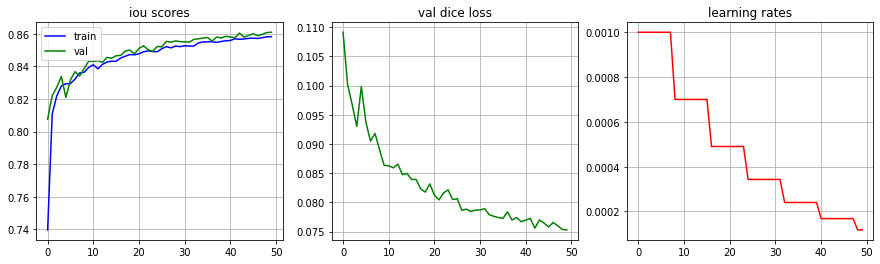

In [97]:
best_score = run_training(epochs=50, 
                          lr=0.0010, 
                          batch_size=26,  
                          loss=loss, 
                          show_metrics=True,
                          device=device, 
                          optuna=False)

### Compare New and Old Model :



In [ ]:
!git clone https://github.com/DevoLearn/devolearn.git
!cp -r /content/drive/MyDrive/mydata/3d_seg_data/training_data.zip /content/
!unzip training_data.zip
!cp -r /content/drive/MyDrive/mydata/3d_seg_data/metadata.csv /content/

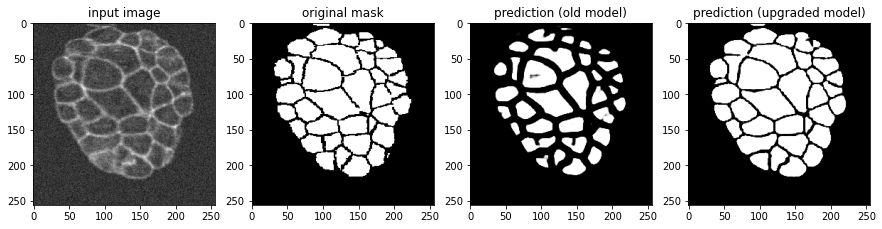

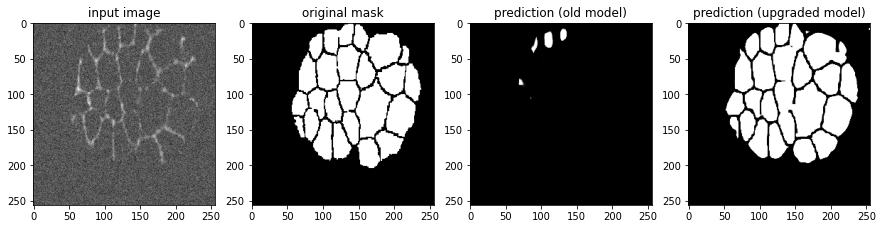

In [135]:
model_new = torch.load('/content/best_model.pth')
#model_new = torch.load('best_1.pth')
model_old = torch.load('/content/devolearn/devolearn/embryo_segmentor/3d_segmentation_model.pth')
model_new.eval()
model_old.eval()
val_loader = DataLoader(dataset=test_dataset, batch_size=2, shuffle = True, num_workers=2)
image, masks = next(iter(val_loader))
 
for i in range(len(image)):
    inp = image[i].cuda().unsqueeze(0)
    pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    show_img = inp.cpu()[0][0]
    show_pred_old = model_old(inp).squeeze(0).squeeze(0).detach().cpu()
    show_pred_new = model_new(inp).squeeze(0).squeeze(0).detach().cpu()

    show_mask = masks[i][0].cpu()
    fig, ax = plt.subplots(1,4, figsize = (15,35))
 
    ax.flat[0].imshow(show_img, cmap='gray')
    ax.flat[0].title.set_text('input image')
    
    ax.flat[1].imshow(show_mask, cmap='gray')
    ax.flat[1].title.set_text('original mask')
 
    ax.flat[2].imshow(show_pred_old, cmap='gray')
    ax.flat[2].title.set_text('prediction (old model)')

    ax.flat[3].imshow(show_pred_new, cmap='gray')
    ax.flat[3].title.set_text('prediction (upgraded model)')

In [ ]:
df = pd.read_csv('metadata.csv')
exp = []
images = df.image.values
for i in range(len(images)):
    if images[i][-6:] == "35.jpg":
        exp.append(images[i])
exp = np.sort(np.array(exp))
mini_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((256,256), interpolation = Image.NEAREST),
                                     transforms.ToTensor()
                                     ])

def path_to_result(path, mode_old, model_new):
    model.eval()
    im = cv2.imread(path,0)
    image = np.array(Image.open(path))
    tensor = mini_transform(im).unsqueeze(0).cuda()
    res_old = model_old(tensor).detach().cpu().numpy()[0][0]
    res_new = model_new(tensor).detach().cpu().numpy()[0][0]
    return(res_old, res_new)

exp = ["training_data/images/real_" + str(i) + "_35.jpg" for i in range(17, 95)]
model.eval()

save_folder = "animation_frames"
os.mkdir(save_folder)
for i in range(len(exp)):
    savename = save_folder + "/" + str(i) + ".png"
    fig, ax = plt.subplots(1,3, figsize = (12,4))
    pred_old, pred_new = path_to_result(exp[i], model_old, model_new)
    image = cv2.imread(exp[i],0)
    pred_old, pred_new = cv2.resize(pred_old, image.shape[::-1]), cv2.resize(pred_new, image.shape[::-1])
    clear_output(wait= True)

    ax.flat[0].imshow(image)
    ax.flat[0].title.set_text('input')
    ax.flat[1].imshow(pred_old, cmap = "gray")
    ax.flat[1].title.set_text('prediction (old model)')
    ax.flat[2].imshow(pred_new, cmap = "gray")
    ax.flat[2].title.set_text('prediction (upgraded model)')
    fig.savefig(savename)

In [ ]:
names = [ "/content/animation_frames/" + str(i) + ".png" for i in range (0, len(exp), 1)]
images = []
for n in names:
    frame = Image.open(n)
    images.append(frame)
print(len(images))

images[0].save('comparision_old_new_7.gif',
               save_all=True,
               append_images=images[1:],
               duration=100,
               loop=0)

In [ ]:
!cp -r /content/animation_frames /content/drive/MyDrive/mydata/3d_seg_data/

In [107]:
!cp -r /content/best_model.pth /content/drive/MyDrive/mydata/3d_seg_data/best_2.pth